<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/stock-predictions/blob/master/lab.ipynb">link</a>

Helper functions:


In [0]:
import pandas as pd

def one_hot(dataframe, column):
    # use pd.concat to join the new columns with your original dataframe
    df = pd.concat([dataframe, pd.get_dummies(dataframe[column], prefix=column)], axis=1)
    # now drop the original column (you don't need it anymore)
    df.drop([column], axis=1, inplace=True)

    return df

def inner_join(df1, df2, column):
    return pd.concat([df1.set_index(column),df2.set_index(column)], axis=1, join='inner').reset_index()

def where_equal(df, column, value):
    return df[df[column] == value]

def week_from_date(df, column):
    df[column] = pd.to_datetime(df[column], errors='coerce')
    df['week'] = df[column].dt.week
    df = df = one_hot(df, 'week')
    return df

def lags(df, range, key):
    ds = df[key]
    df.drop([key], axis=1, inplace=True)
    stocks = 1115
    concatable = [df, ds.fillna(0)]
    for i in range:
        concatable.append(ds.shift(stocks * i).fillna(0).rename(f'{key}_{i}'))
    return pd.concat(concatable, axis=1)

Now we write our **classificator** for reducing incoming data dimensionality and grouping similar providers. We will use [AgglomerativeClustering](https://https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) for this purpose:

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

import pandas as pd
import numpy as np


train = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/train.csv')
store_states = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/store_states.csv')
store = pd.read_csv('https://raw.githubusercontent.com/kirillzyusko/stock-predictions/master/store.csv')


def get_store_data():
    df = inner_join(store_states, store, 'Store')
    df = one_hot(df, 'State')
    df = one_hot(df, 'StoreType')
    df = one_hot(df, 'Assortment')
    agg = train.groupby('Store')['Sales'].agg([pd.np.mean]).reset_index()
    df = pd.concat([df, agg], axis=1)

    df.drop([
            'PromoInterval',
            'Promo2',
            'Promo2SinceWeek',
            'Promo2SinceYear',
            'CompetitionDistance',
            'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear'
        ], axis=1, inplace=True)
    
    return df.loc[:,~df.columns.duplicated()]

train_data = get_store_data()
train_data.drop(['Store'], axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler().fit_transform(train_data)

print(standardized_data)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,200))

#visualizer.fit(standardized_data)  # Fit the data to the visualizer
#visualizer.show()  # Finalize and render the figure

K = 500 # num of clusters
model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')# KMeans(n_clusters=K)
predicted = model.fit_predict(standardized_data)

print(predicted)
store.insert(loc=0, column='K', value=predicted)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[[-0.29988593 -0.26468393 -0.43876345 ... -0.09020772 -0.92312484
  -0.88857955]
 [-0.29988593 -0.26468393 -0.43876345 ... -0.09020772 -0.92312484
  -0.80190926]
 [-0.29988593 -0.26468393 -0.43876345 ... -0.09020772 -0.92312484
  -0.01078783]
 ...
 [-0.29988593 -0.26468393 -0.43876345 ... -0.09020772  1.0832771
  -0.12081961]
 [-0.29988593 -0.26468393 -0.43876345 ... -0.09020772  1.0832771
   5.59115669]
 [-0.29988593 -0.26468393 -0.43876345 ... -0.09020772  1.0832771
  -0.2630245 ]]
[113 248 151 ... 176 261 323]


First pipeline - data processing, including: one-hot encoding, adding time lags and so on

In [0]:
def get_data():
    df = one_hot(train, 'DayOfWeek')
    df = week_from_date(df, 'Date')
    store = get_store_data()

    df = inner_join(df, store, 'Store')
    #df = one_hot(df, 'StoreType')
    #df = one_hot(df, 'Assortment')
    df = one_hot(df, 'K')
    #df = one_hot(df, 'Store')
    # df = lags(df, [1,2,3,4,5,6,7,8,9,10,11,12,13,14], 'Sales')

    df.drop([
        'StateHoliday',
        'SchoolHoliday',
        'Date',
        'Store',
        #'Customers',
    ], axis=1, inplace=True)

    # df = where_equal(df, 'Store', 1)
    # print(list(df))

    return df

def to_3d(n=1115):
    df = get_data()
    olap = []
    for i in range(n):
        olap.append(where_equal(df, 'Store', i))

    return olap

In [4]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = get_data()

y = data['Sales']
data.drop(['Sales'], axis=1, inplace=True)
X = data

scaler = StandardScaler()
standardized_data = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(standardized_data, y, test_size=0.25, random_state=42)

length, features = X_train.shape

model = Sequential()

model.add(Dense(int(1774), input_dim=features, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu', name='hidden_1'))
model.add(Dense(int(1774), input_dim=features, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu', name='hidden_12'))
#model.add(Dropout(0.4, name='dropout_1'))

model.add(Dense(int(1183), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_2'))
model.add(Dense(int(1183), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_21'))
model.add(Dense(int(1183), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_22'))
#model.add(Dropout(0.4, name='dropout_2'))

model.add(Dense(int(591), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_3'))
model.add(Dense(int(591), kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_31'))
#model.add(Dropout(0.5, name='dropout_3'))

model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), name='output_layer'))

# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model.summary())

model.fit(X_train, y_train,
          epochs=10,
          validation_data=(X_test, y_test),
          verbose=1)

score = model.evaluate(X_test, y_test, verbose=0)
print(score)

Using TensorFlow backend.






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 1774)              1036016   
_________________________________________________________________
hidden_12 (Dense)            (None, 1774)              3148850   
_________________________________________________________________
hidden_2 (Dense)             (None, 1183)              2099825   
_________________________________________________________________
hidden_21 (Dense)            (None, 1183)              1400672   
_________________________________________________________________
hidden_22 (Dense)            (None, 1183)              1400672   
_________________________________________________________________
hidden_3 (Dense)             (None, 591)               699744    
_________________________________________________________________
hidden_31 (Dense)            (None, 591)          

Check predictions using charts:

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


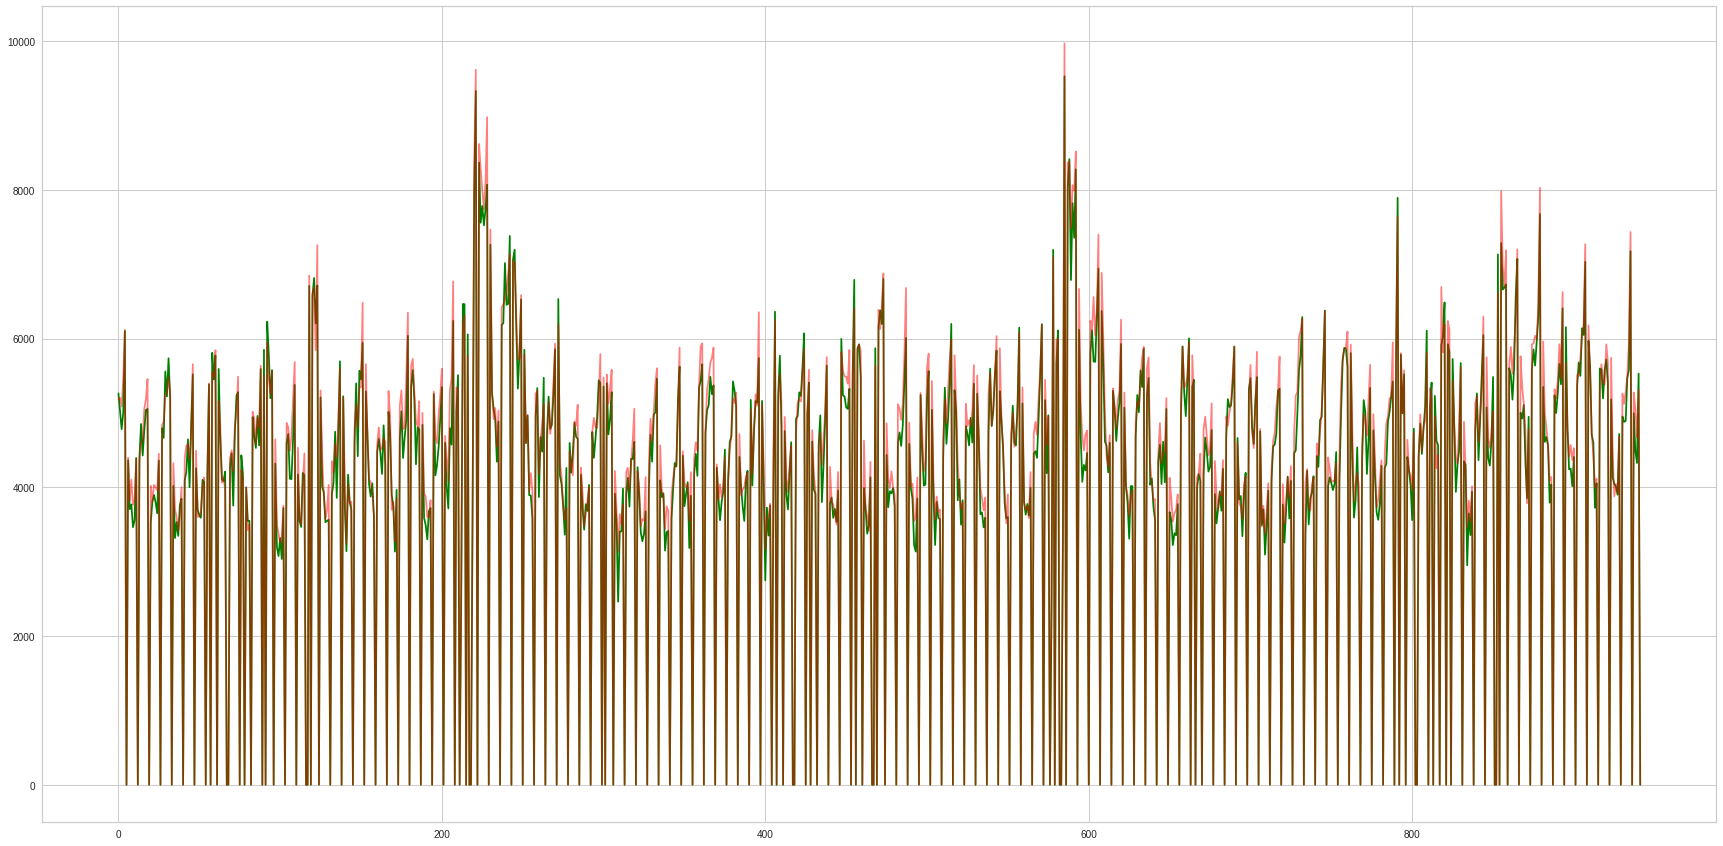

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


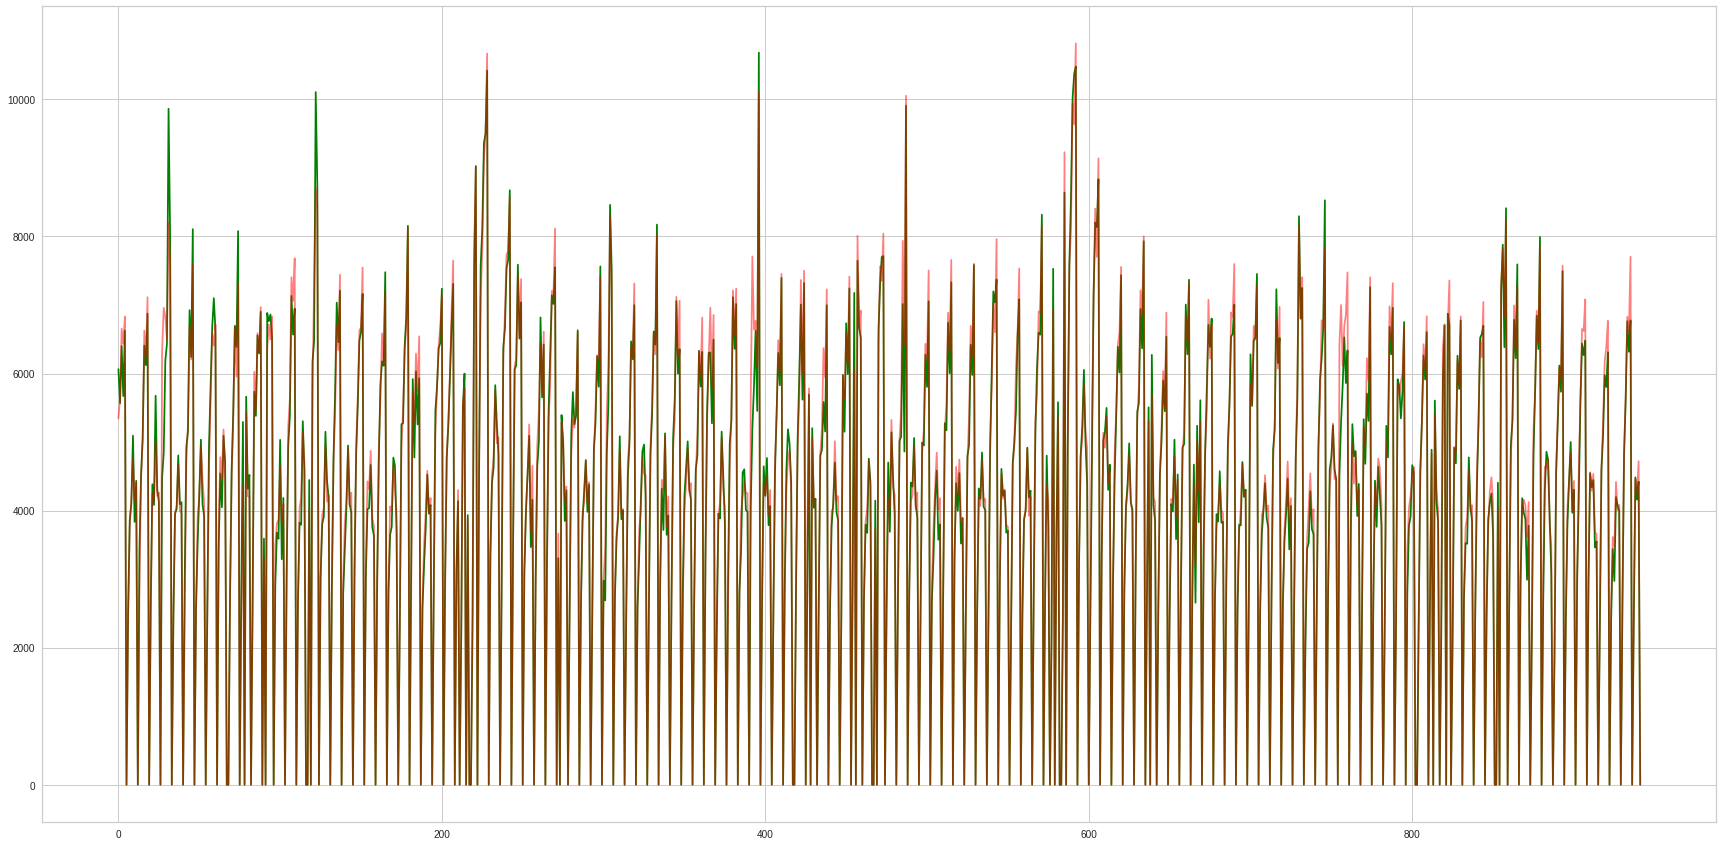

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


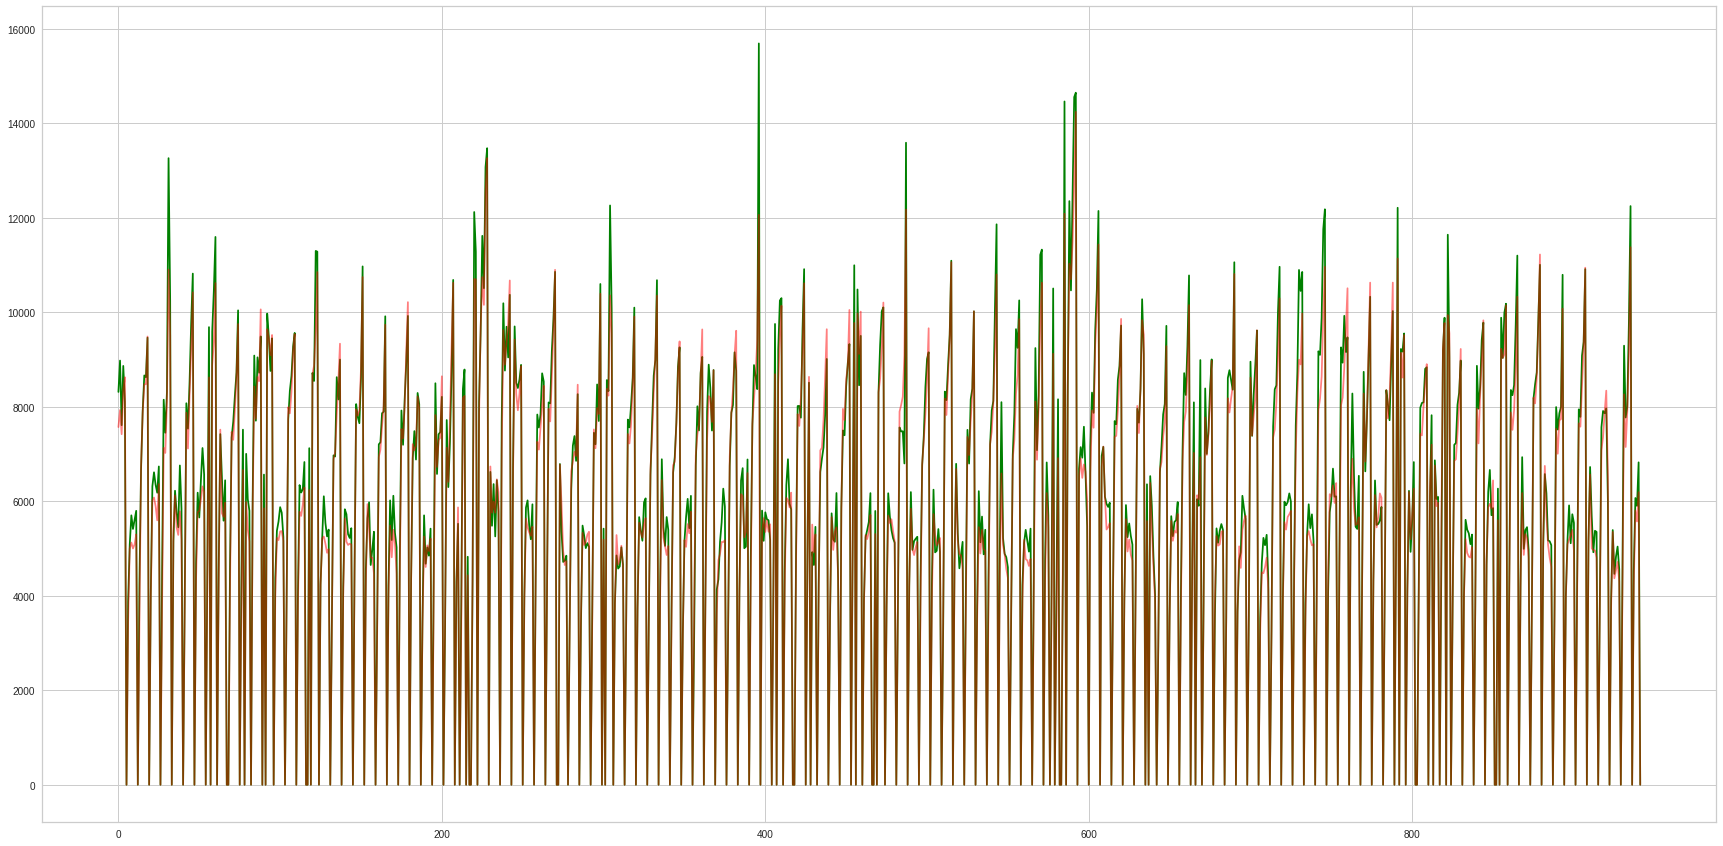

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


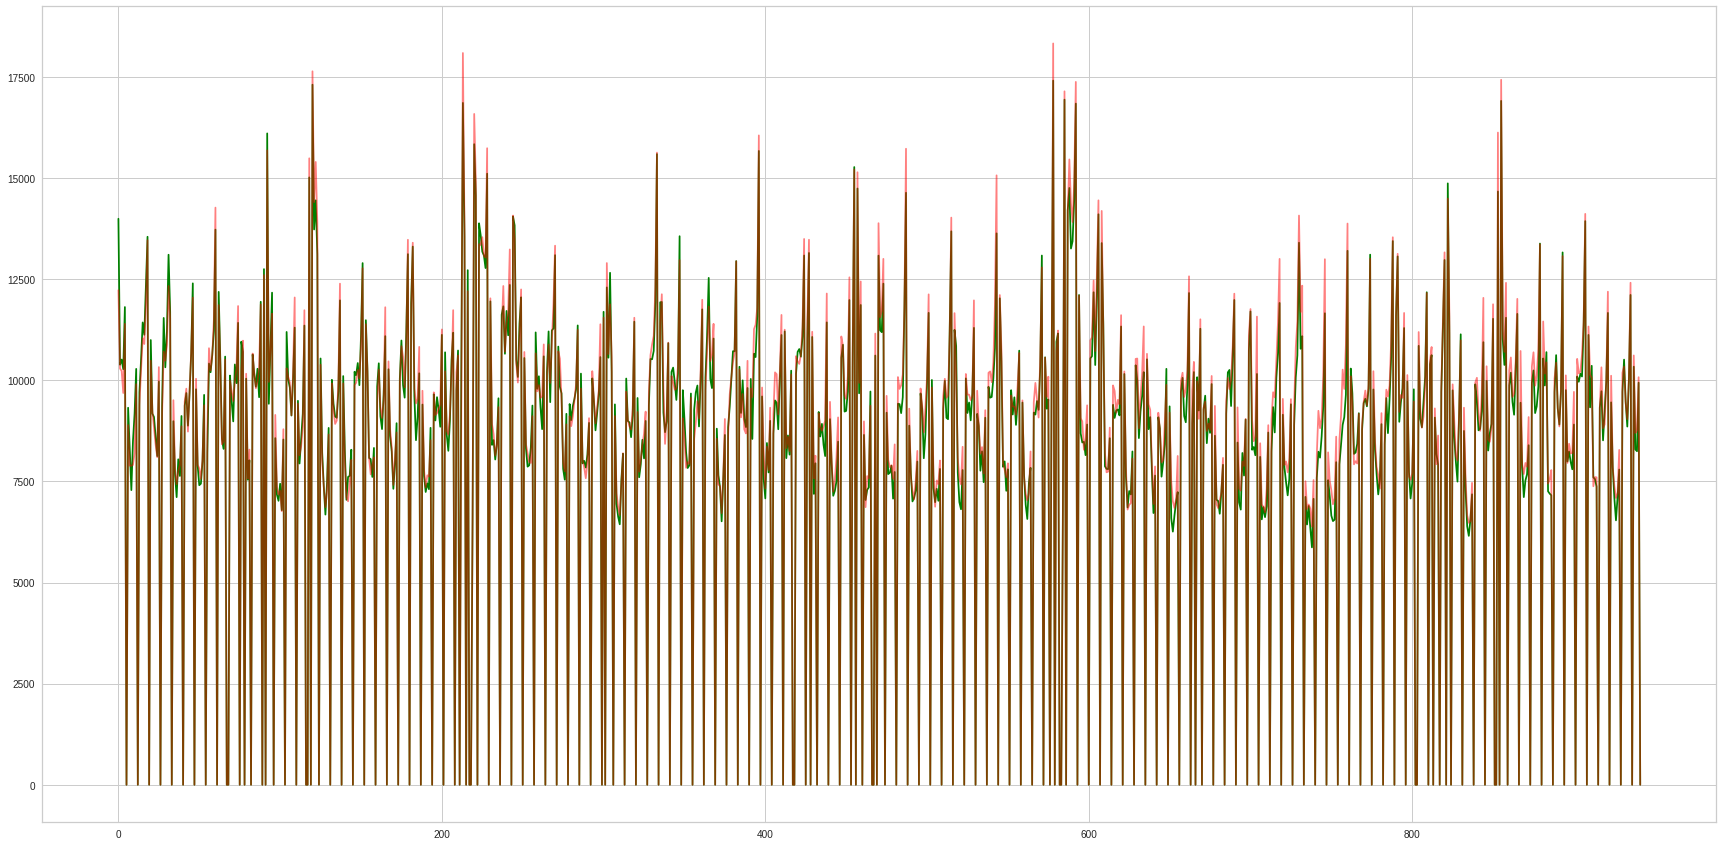

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


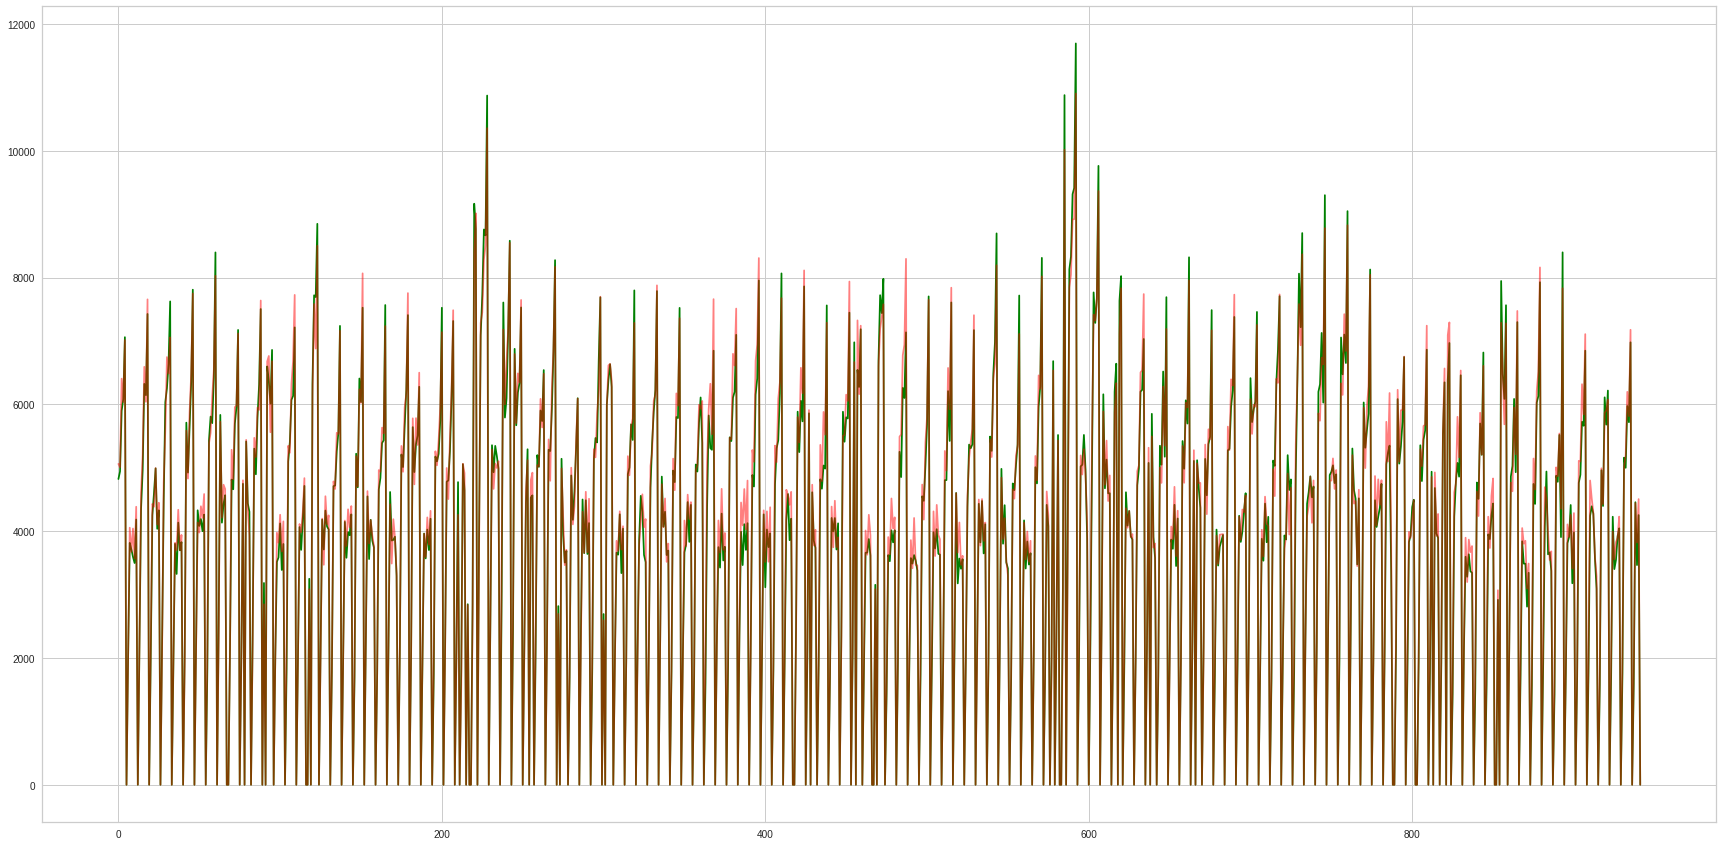

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]

data = get_data()

def draw_chart(id=1):
    y_vis = data[data[f'Store'] == id]['Sales']
    X_vis = data[data[f'Store'] == id]

    X_vis.drop(['Sales'], axis=1, inplace=True)

    X_vis = scaler.transform(X_vis)

    plt.plot(range(len(y_vis)), y_vis, color='green')
    plt.plot(range(len(y_vis)), model.predict(X_vis).flatten(), color='red', alpha=0.5)
    plt.show()

draw_chart(1)
draw_chart(2)
draw_chart(3)
draw_chart(4)
draw_chart(5)